In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from data.cleaning import get_dataset_from_pickle
from models.utils import adfuller_test, create_weekly_heatmap
from models.autoregressive import ARIMA, SARIMAX
from models.fbprophet import FacebookProphet
from models.lstm import CNN_LSTM_Model

/Users/evan-datum/Documents/Personal/Data Science/Projects/strategic-parking-enforcement/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# City of Los Angeles: Proposing a Strategy for Optimizing Parking Enforcement Deployment

**Author: Evan Gabrielson**

---

A strategy for improving the efficiency of LADOT's Parking Enforcement division should function to save the city and citizenry of Los Angeles money. From public data published by the City of LA on their [Open Budget Explorer](https://openbudget.lacity.org/#!/year/2023/operating/0/department_name/Transportation/0/program_name/Parking+Enforcement+Services/0/source_fund_name), we can see that full and part-time salaries as well as overtime account for over 99% of allocated funding. While the official number of officers is not published publicly, we can use budget data and Indeed job postings by the City of LA to create a heuristic for the number of Full-Time Officers (FTO) working for the Parking Enforcement division.

$$\text{FTO Salary} = (\$23.00 \text{ per hour}) * (40 \text{ hours per week}) * (52 \text{ weeks per year}) =  \$47,840 \text{ annually}$$
$$\text{Number of FTOs} = \$58,311,479 \text{ budgeted for salaries } / \text{ } \$47,840 \text{ per FTO salary} = 1,218 \text{ FTOs}$$

In [ ]:
fto_salary = 23 * 40 * 52
num_ftos = 58.3e6 // fto_salary
print(f"Number of FTOs: {num_ftos}")


It appears that over **1218 full-time officer units** are working for the LADOT Parking Enforcement division. 

As previously stated, to optimize the City of LA's budget, profits must be maximized per officer deployed in a given region for a given shift. We can use historical parking citation data to understand the distribution of citations (1) spatially, across the various regions of Los Angeles, and (2) temporally, across the different days of the week. The citation density distribution is significant to the City of LA's budget optimization problem because it is __directly proportional to the maximum potential revenue that can be generated by the parking enforcement department__. Once a predictor for this distribution is known, we can better estimate the demand for enforcement officers by region and time to maximize revenue per officer.

#### Data Preparations
For the sake of the simplicity of this initial study, we will focus on citation data only in the district of Hollywood. We will revisit the other districts in a final modeling stage to ensure district-to-district discrepancies are correctly incorporated in the models and to allow a complete view of the City of LA's potential budget savings.

In [2]:
# Load full timeseries
citations_ts = get_dataset_from_pickle('data/pickle/timeseries.pickle')

# Extract Hollywood-specific data
hollywood_ts = citations_ts[citations_ts['district'] == 'Hollywood']['citation_count']
hollywood_ts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 87555 entries, 2013-12-31 08:00:00 to 2023-12-27 10:00:00
Series name: citation_count
Non-Null Count  Dtype
--------------  -----
87555 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB


#### Looking at Hollywood's Mean Weekly Citation Density

The most rudimentary approach to predicting citation density by hour and weekday is to look at an average of the citation density values across the entire timeseries for each combination of hour and weekday. It would be reasonable to assume that even this basic approach could represent a deployment scheme offering already considerable savings for the City of Los Angeles. Later on, we will examine models that take into account week-by-week differences in citation density to further enhance our savings and deployment demand prediction service.

In [ ]:
create_weekly_heatmap(hollywood_ts)

#### Check for stationarity

Before timeseries modeling can begin, we'll use the Dickey-Fuller test for stationarity and isolate districts that are not stationary on a daily basis.

**Aside:** Testing for non-stationarity with Dickey Fuller

It is important for the sake of modeling and regression techniques that our timeseries is stationary. The Dickey Fuller test allows us to determine whether our timeseries is stationary by trying to establish a value for coefficient $\rho$ in the following equation assuming our timeseries is non-stationary:

$$
x_t = \alpha + \rho x_{t-1} + \epsilon_t \quad \text{where } \alpha = \text{drift \& } \epsilon_t = \text{error term}
$$

By the definition of stationarity, we want to determine if the change in our timeseries ($\Delta x_t$) has a tendency to return to some mean. This would only occur if $\rho$ was less than 1.

$$
\Delta x_t = (\rho - 1) x_{t-1} + \epsilon_t
$$

$$
H_0 : \rho = 1 \quad \text{stationary}\\
H_1 : \rho < 1 \quad \text{non stationary}
$$

In [ ]:
# Print (Augmented) Dickey-Fuller test results
adfuller_test(hollywood_ts)

### Basic Model - ARIMA

Let's split the training and test set and get a baseline model that predicts a constant citation count for all future timesteps. We'll use an ARIMA model with 0 autoregressive (AR) terms and 0 moving average (MA) filter terms to find the future citation count.

In [8]:
# Run basic ARIMA Model
arima_model = ARIMA(hollywood_ts, split=0.8)
arima_model.fit(order=(0, 0, 0))
arima_model.results.summary()

/Users/evan-datum/Documents/Personal/Data Science/Projects/strategic-parking-enforcement/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/evan-datum/Documents/Personal/Data Science/Projects/strategic-parking-enforcement/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/evan-datum/Documents/Personal/Data Science/Projects/strategic-parking-enforcement/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         citation_count   No. Observations:                70044
Model:                          ARIMA   Log Likelihood             -451160.333
Date:                Wed, 21 Aug 2024   AIC                         902324.667
Time:                        11:06:23   BIC                         902342.980
Sample:                    12-31-2013   HQIC                        902330.315
                         - 12-27-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.2548      0.928     64.924      0.000      58.436      62.074
sigma2      2.302e+04     42.308    544.042      0.000    2.29e+04    2.31e+04
===================================================================================
Ljung-Box (L1) (Q):               31334.10   Jarque-Bera (JB):           5539188.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             5.23
Prob(H) (two-sided):                  0.62   Kurtosis:                        45.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The [Akaike Information Criterion (AIC)](https://iowabiostat.github.io/research-highlights/joe/Cavanaugh_Neath_2019.pdf) value is an estimator of model quality, which when minimized results in the optimal model in terms of simplicity and accuracy. We can compare the AIC value of our Basic ARIMA Model (in this case: 902324) with the AIC value of more advanced modeling techniques to determine whether or not our more advanced models should be preferred.

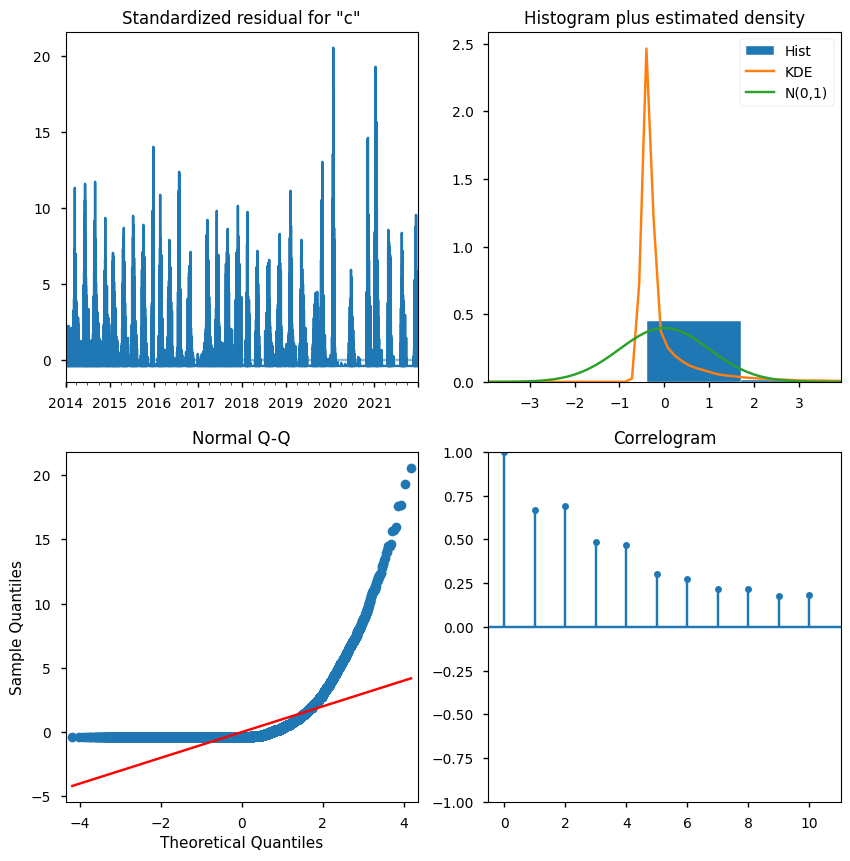

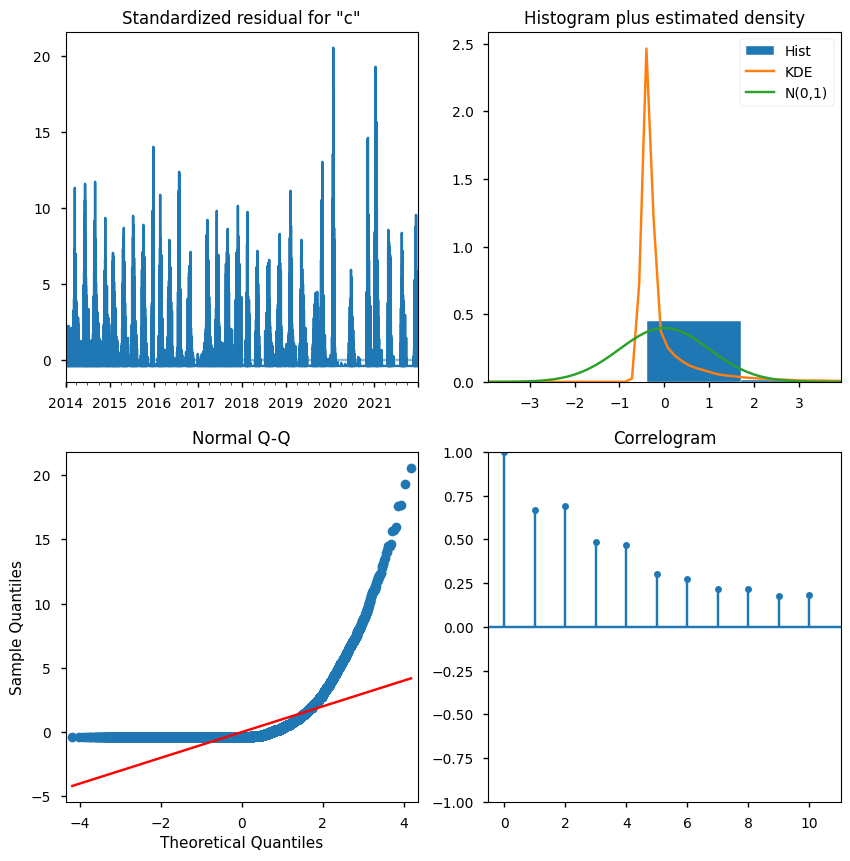

In [9]:
arima_model.plot_diagnostics()

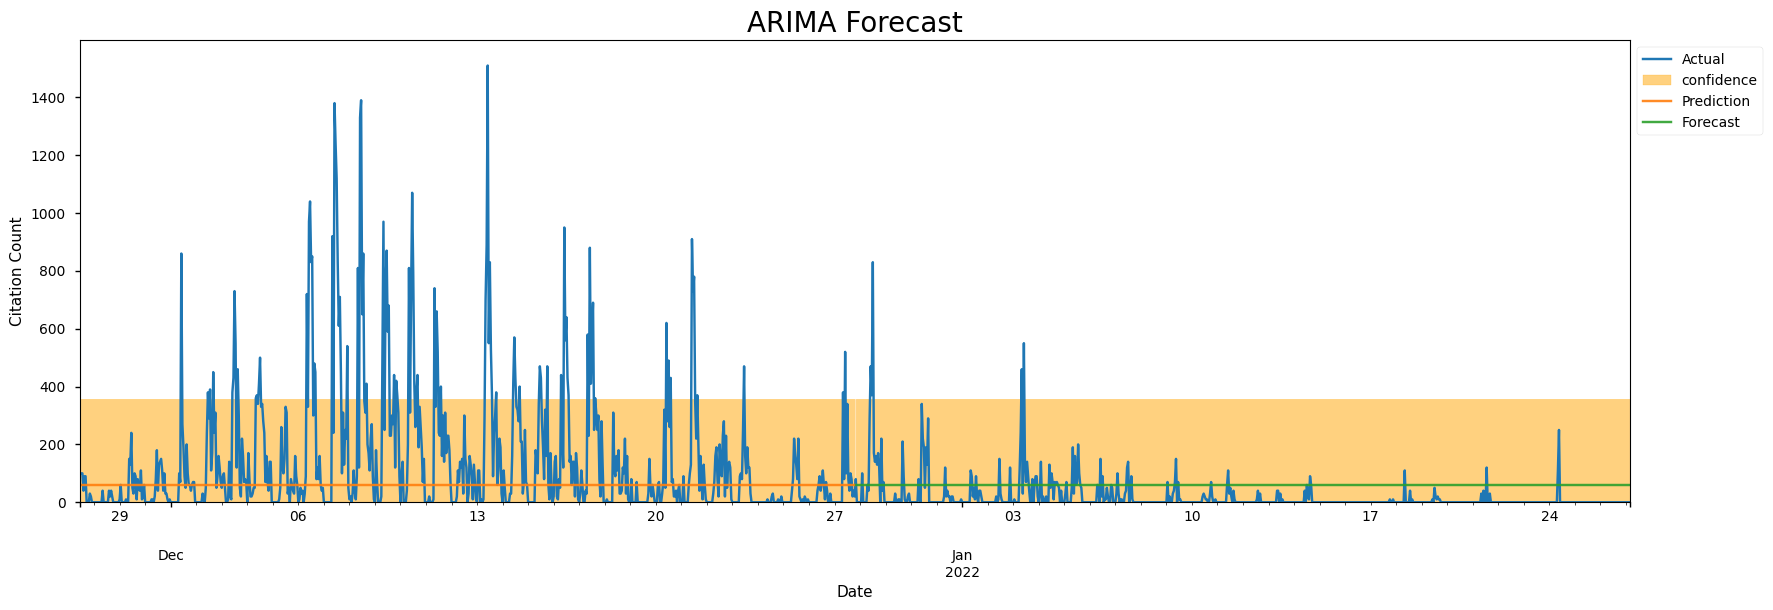

In [10]:
# Plot the trivial model
arima_model.predict()
arima_model.plot()

In [11]:
# Print RSME and ACF plots
arima_model.measure()

Training Set RMSE: 242.6833955643456
Testing Set RMSE: 73.52807048008745


In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_acf(arima_model.train, lags=100)
plot_pacf(arima_model.train, lags=100)

### SARIMA Model
Capturing seasonality is important, we'll use a 24 hour period to try and pick up any daily seasonality. In order to isolate the best parameters, we'll use the `auto_arima` function to search across autoregressive (AR), differencing (I) and moving average (MA) terms, as well as seasonal components.

In [12]:
# Instantiate SARIMAX model
sarimax_model = SARIMAX(hollywood_ts, split=0.8)

# Run SARIMAX Model Grid Search & print results
# sarimax_model.grid_search(max_value=2, display=True)

In [ ]:
best_order, best_seasonal_order, best_aic = sarimax_model.get_best_params()
print(f"""
      Best SARIMAX Parameters:
      ------------------------
      Order: {best_order}
      Seasonal Order: {best_seasonal_order}
      AIC Value: {best_aic}
    """)
sarimax_model.grid_search_results.to_pickle('data/pickle/sarimax_results.pickle')

In [13]:
sarimax_results = pd.read_pickle('data/pickle/sarimax_results.pickle')
best_order, best_seasonal_order = sarimax_results.iloc[0, :3].values, sarimax_results.iloc[0, 3:-1].values
sarimax_model.fit(order=best_order, s_order=best_seasonal_order)
sarimax_model.results.summary()

/Users/evan-datum/Documents/Personal/Data Science/Projects/strategic-parking-enforcement/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/evan-datum/Documents/Personal/Data Science/Projects/strategic-parking-enforcement/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15791D+00    |proj g|=  1.01957D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   1.014D-05   6.158D+00
  F =   6.1579122656657095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         citation_count   No. Observations:                70044
Model:               SARIMAX(1, 0, 0)   Log Likelihood             -431324.807
Date:                Wed, 21 Aug 2024   AIC                         862653.613
Time:                        11:07:57   BIC                         862671.927
Sample:                    12-31-2013   HQIC                        862659.262
                         - 12-27-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7139      0.001    964.687      0.000       0.712       0.715
sigma2      1.307e+04     13.573    962.998      0.000     1.3e+04    1.31e+04
===================================================================================
Ljung-Box (L1) (Q):                8697.12   Jarque-Bera (JB):           8907108.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             4.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
sarimax_model.results.plot_diagnostics(figsize=(10,10))

In [14]:
# Get SARIMA predictions
sarimax_model.predict()

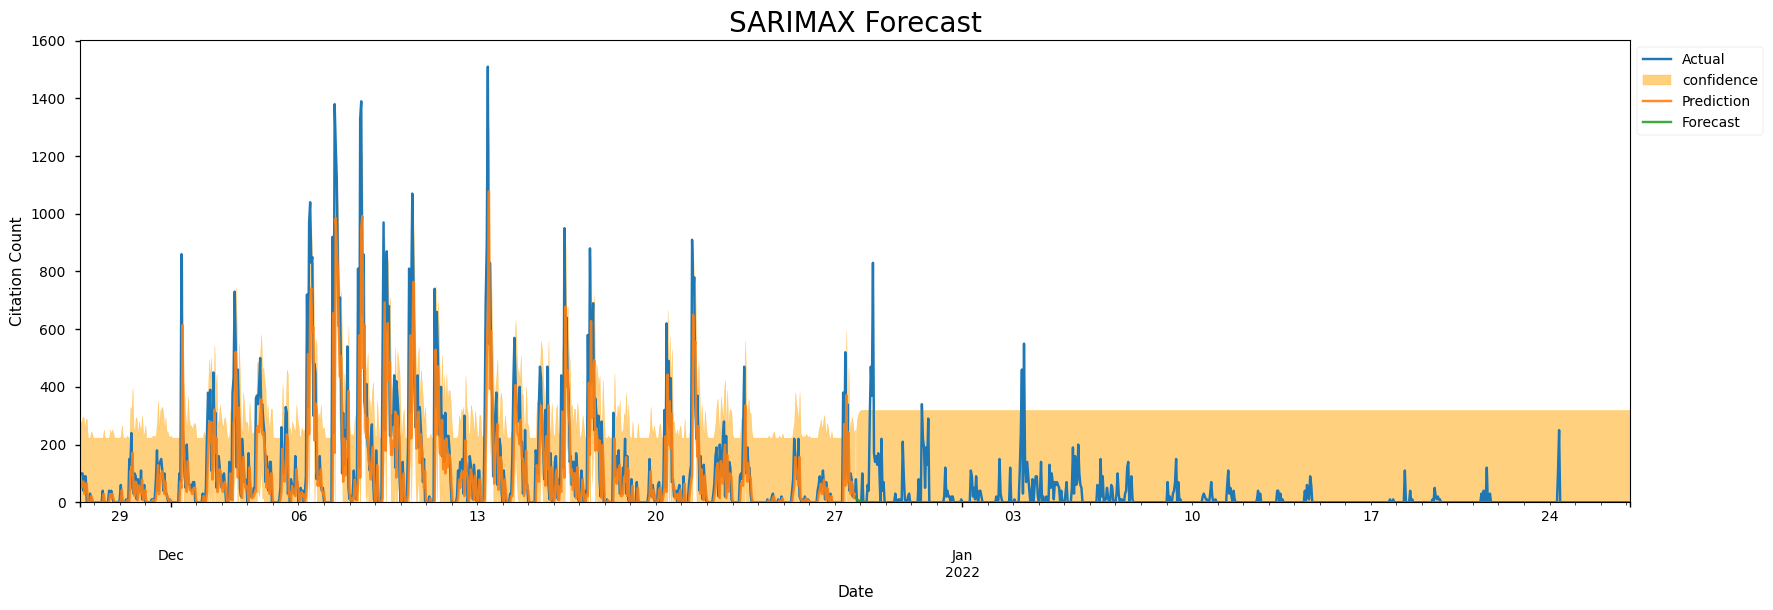

In [15]:
# Plot SARIMA predictions
sarimax_model.plot()

In [16]:
# Determine RMSE for SARIMAX
sarimax_model.measure()

Training Set RMSE: 174.15815660748692
Testing Set RMSE: 64.3107090998068


### Facebook Prophet

In [6]:
# Instantiate the Facebook Prophet model
prophet_model = FacebookProphet(hollywood_ts, split=0.8)

# Fit the model to the training set
prophet_model.fit()

09:28:06 - cmdstanpy - INFO - Chain [1] start processing
09:28:07 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
# Generate forecasts
prophet_model.predict()
prophet_model.fore[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
87550,2023-12-27 06:00:00,16.526669,-166.321764,198.504884
87551,2023-12-27 07:00:00,44.921375,-142.151118,227.093727
87552,2023-12-27 08:00:00,82.899755,-90.398386,270.188920
87553,2023-12-27 09:00:00,121.573500,-59.080424,299.671901
87554,2023-12-27 10:00:00,148.776440,-33.075363,317.640405


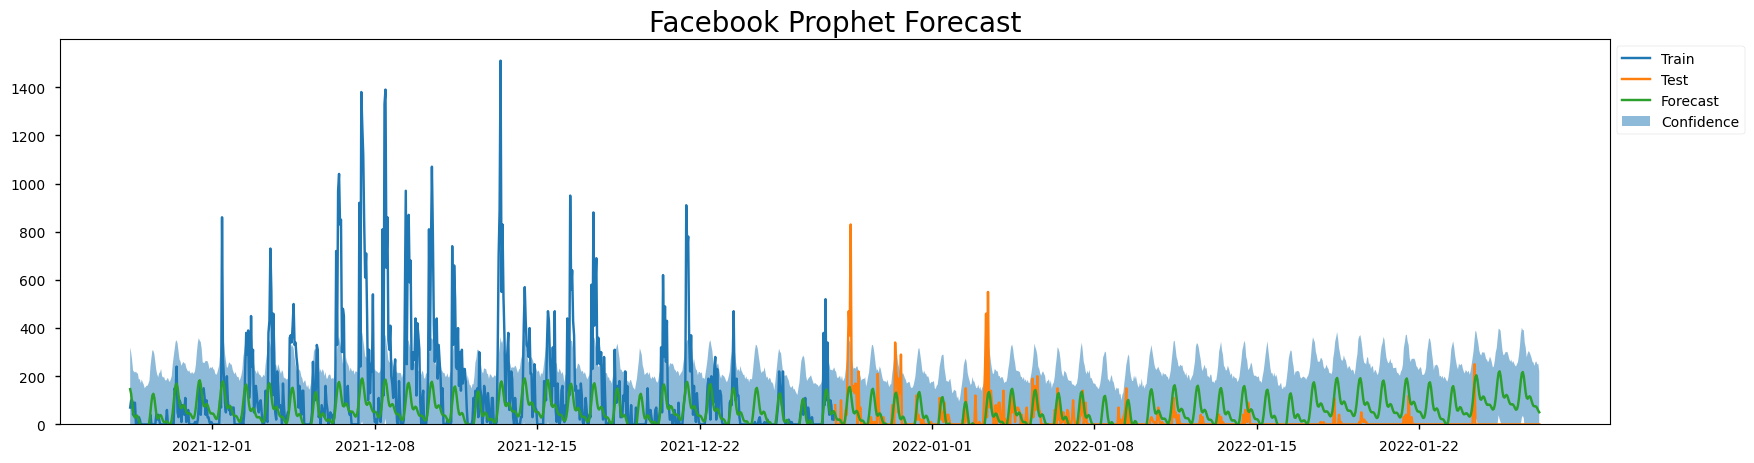

In [8]:
# Plot Facebook Prophet
prophet_model.plot()

In [9]:
# Display RMSE
prophet_model.measure()

Training Set RMSE: 216.00224764128365
Testing Set RMSE: 83.17835101354174


Holidays can have a significant impact on traffic and whether or not parking enforcement is deployed on a given day.
Facebook Prophet has built-in support for indicating if a data point falls on a U.S. holiday or California holiday.
Behind the scenes, Prophet uses the [holidays](https://python-holidays.readthedocs.io/en/latest/index.html) Python package.
We can use the Facebook Prophet with Holidays results to determine if this method improves or weakens our model.

In [3]:
# Instantiate the Facebook Prophet model
prophet_model_w_holidays = FacebookProphet(hollywood_ts, split=0.8)

# Fit the model to the training set
prophet_model_w_holidays.fit(add_holidays=True)

# Generate forecasts
prophet_model_w_holidays.predict()
prophet_model_w_holidays.fore[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

09:23:36 - cmdstanpy - INFO - Chain [1] start processing
09:23:37 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
87550,2023-12-27 06:00:00,19.571250,-159.097723,206.520964
87551,2023-12-27 07:00:00,48.096705,-122.278363,233.092834
87552,2023-12-27 08:00:00,86.214039,-99.334325,274.704851
87553,2023-12-27 09:00:00,125.033173,-58.475064,303.208786
87554,2023-12-27 10:00:00,152.386195,-22.677740,333.169744


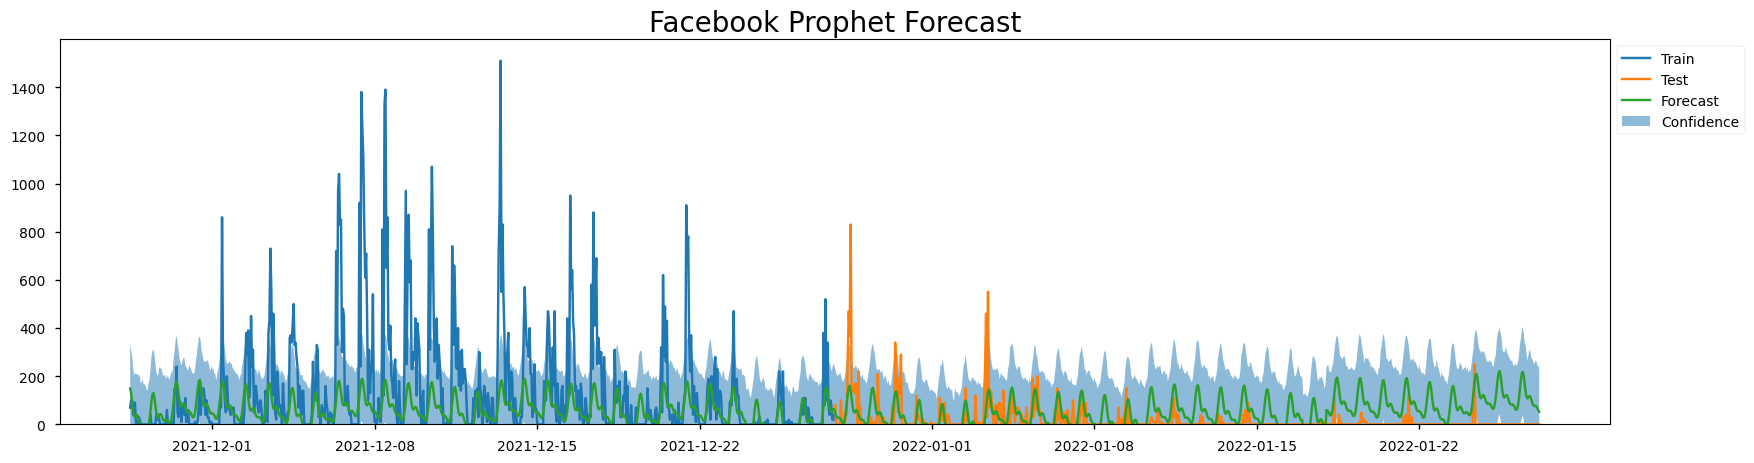

In [4]:
# Plot Facebook Prophet
prophet_model_w_holidays.plot()

In [5]:
# Display RMSE
prophet_model_w_holidays.measure()

Training Set RMSE: 215.81918296058237
Testing Set RMSE: 83.0212078126962


The RMSE scores for Prophet with and without Holidays are comparable, meaning that an indication of whether a data point fell on a Holiday was not significant for timeseries forecasting. Continuing, we should look into using a more complex neural network model that might be able to capture those stark groupings of peaks.

### CNN-LSTM

So far, we've focused on the Hollywood District to identify daily and weekly trends in hourly citation count. There is still a ton of room for improvement so let's see if a more complex model like a Convolutional Neural Network (CNN) with Long Short-Term Memory (LSTM) better captures complex seasonality.

The CNN-LSTM model leverages the strengths of both CNNs and LSTM networks. CNNs are great for extracting local patterns in data, while LSTMs are powerful in capturing long-term dependencies in sequential data. The combination of these architectures allows for effective feature extraction and sequence modeling, making the CNN-LSTM model a robust choice for time series forecasting.

#### Model Architecture

**Convolutional Layers**

In [3]:
dl_hollywood_ts = hollywood_ts.reset_index().rename(columns={'issue_datetime': 'x', 'citation_count': 'y'})

# Hyperparameters
config = {
    "n_seq": 4,          # Sub-sequences
    "n_steps": 12,       # Steps per sub-sequence
    "n_filters": 64,     # Output filters from convolution
    "n_kernel": 3,       # Convolutional window size
    "n_nodes": 100,      # Nodes in LSTM & dense layers
    "n_epochs": 50,      # Number of epochs to run
    "n_batch": 100       # Batch size
}

# Initialize CNN-LSTM Model object
cnn_lstm_model = CNN_LSTM_Model(dl_hollywood_ts, config)

Instantiating CNN-LSTM model . . .

CNN LSTM Parameters:
- - - - - - - - - - -
CNN  | Output Filters: 64
CNN  | Convolution Window Size: 3
LSTM | Subsequence Steps: 12
FC   | Nodes in LSTM / FC Layers: 100



/Users/evan-datum/Documents/Personal/Data Science/Projects/strategic-parking-enforcement/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [4]:
# Create data loaders for training and testing sets
cnn_lstm_model.load()

Loading completed. . .



In [5]:
# Train the model
cnn_lstm_model.train_model()

Starting model training. . .

Epoch 1/50, Training Loss: 18064.3719
Epoch 1/50, Testing Loss: 14518.4104
Epoch 2/50, Training Loss: 12176.6410
Epoch 2/50, Testing Loss: 11144.3851
Epoch 3/50, Training Loss: 11109.6480
Epoch 3/50, Testing Loss: 11724.2336
Epoch 4/50, Training Loss: 10784.4746
Epoch 4/50, Testing Loss: 10513.4665
Epoch 5/50, Training Loss: 10426.3375
Epoch 5/50, Testing Loss: 10376.1796
Epoch 6/50, Training Loss: 10029.5109
Epoch 6/50, Testing Loss: 10517.8759
Epoch 7/50, Training Loss: 9665.3726
Epoch 7/50, Testing Loss: 10120.7066
Epoch 8/50, Training Loss: 9765.2041
Epoch 8/50, Testing Loss: 9714.7180
Epoch 9/50, Training Loss: 9702.7648
Epoch 9/50, Testing Loss: 10555.9903
Epoch 10/50, Training Loss: 9585.7599
Epoch 10/50, Testing Loss: 10056.9596
Epoch 11/50, Training Loss: 9853.6578
Epoch 11/50, Testing Loss: 10458.1903
Epoch 12/50, Training Loss: 9478.8109
Epoch 12/50, Testing Loss: 10224.5856
Epoch 13/50, Training Loss: 9233.8172
Epoch 13/50, Testing Loss: 9802.5

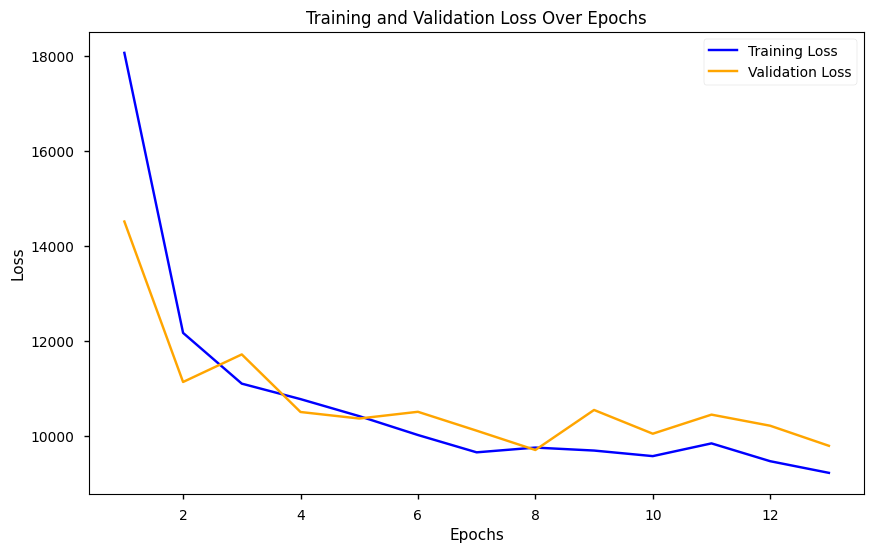

In [6]:
# Plot training and validation losses
cnn_lstm_model.loss_plot()

In [7]:
# Compute RMSE
cnn_lstm_model.measure()

Training RMSE: 96.1265, Testing RMSE: 99.0078


In [8]:
import torch

torch.save(cnn_lstm_model.model.state_dict(), 'cnn_lstm_1_0.pth')
# Save model state
# cnn_lstm_model.save_state()

### Addendum

#### RMSE Hollywood Results by Architecture

| Architecture | Training RMSE | Testing RMSE |
| ------------ | ------------- | ------------ |
| ARIMA | 242.683 | 73.528 |
| SARIMA | 174.158 | 64.310 |
| Prophet | 216.002 | 83.178 |
| Prophet w/ Holidays | 215.819 | 83.021 |
| CNN-LSTM w/ No Dropout | 90.5106 | 95.0561 |
| CNN-LSTM w/ p=0.8 Dropout | 83.2860 | 91.5634 |
| CNN-LSTM w/ p=0.5 Dropout | 96.1265 | 99.0078 |

#### 2023 Holidays

| Date | Holiday |
|------|---------|
| 2023-01-01 | New Year's Day |
| 2023-01-02 | New Year's Day (observed) |
| 2023-05-29 | Memorial Day |
| 2023-06-19 | Juneteenth National Independence Day |
| 2023-07-04 | Independence Day |
| 2023-09-04 | Labor Day |
| 2023-11-11 | Veterans Day |
| 2023-11-10 | Veterans Day (observed) |
| 2023-11-23 | Thanksgiving |
| 2023-12-25 | Christmas Day |
| 2023-01-16 | Martin Luther King Jr. Day |
| 2023-02-20 | Washington's Birthday |
| 2023-02-15 | Susan B. Anthony Day |
| 2023-03-31 | Cesar Chavez Day |
| 2023-11-24 | Day After Thanksgiving |